# Import Data

In [121]:
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

In [122]:
data = pd.read_json('data.json').dropna()
data_with_energy_score = pd.read_json('data_with_energy_score.json').dropna()

# Train Test Split

In [123]:
X = data.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis=1)
y = data['TotalGHGEmissions']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [125]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Dummy Regressor

In [126]:
dummy = DummyRegressor(strategy='mean')

dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f'Dummy Regressor - Best R^2 Score : {r2_dummy:.2f}')

Dummy Regressor - Best R^2 Score : -0.00


# Linear Regressor

## Fitting and Predictions

In [127]:
lin_reg = LinearRegression()

param_grid_lr = {
    'fit_intercept': [True, False],
}

grid_search_lr = GridSearchCV(
    lin_reg,
    param_grid_lr,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1
)

In [128]:
%%timeit
grid_search_lr.fit(X_train, y_train)

132 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Results Cross Validation

In [129]:
# Get mean test scores from cross validation
rslt = grid_search_lr.cv_results_.get("mean_test_score")

# Sort the best estimators based on these mean scores
ranked_indices = np.argsort(rslt)[::-1]

for i, (param, score) in enumerate(zip(
    np.array(grid_search_lr.cv_results_.get("params"))[ranked_indices],
    np.round(rslt[ranked_indices], 5)
)):
    print(f"Estimator {i + 1}  - ", *[f"{key}={val} " for key, val in param.items()], f"-->  r2 = {score:.5f}")

Estimator 1  -  fit_intercept=False  -->  r2 = 0.73668
Estimator 2  -  fit_intercept=True  -->  r2 = 0.73377


In [144]:
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regressor: r2 = {r2_lr:.5f}')

Linear Regressor: r2 = 0.74698


# Random Forest Regressor

In [131]:
rf_reg = RandomForestRegressor(random_state=42)

param_grid_rf = [{
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
}]

grid_search_rf = GridSearchCV(
    rf_reg,
    param_grid_rf,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1
)

In [133]:
%%timeit
grid_search_rf.fit(X_train, y_train)

25.7 s ± 555 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Results Cross Validation

In [134]:
# Get mean test scores from cross validation
rslt = grid_search_rf.cv_results_.get("mean_test_score")

# Sort the best estimators based on these mean scores
rank = 3
ranked_indices = np.argsort(rslt)[-rank:][::-1]

print(f"Top {rank} estimators:")

for i, (param, score) in enumerate(zip(
    np.array(grid_search_rf.cv_results_.get("params"))[ranked_indices],
    np.round(rslt[ranked_indices], 5)
)):
    print(f"Estimator {i + 1}  - ", *[f"{key}={val} " for key, val in param.items()], f"-->  r2={score:.5f}")

Top 3 estimators:
Estimator 1  -  max_depth=None  min_samples_split=5  n_estimators=200  -->  r2=0.75377
Estimator 2  -  max_depth=None  min_samples_split=2  n_estimators=200  -->  r2=0.75376
Estimator 3  -  max_depth=None  min_samples_split=10  n_estimators=200  -->  r2=0.75187


In [146]:
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Regressor: r2 = {r2_rf:.5f}')

Random Forest Regressor: r2 = 0.74617


# SHAP

In [136]:
explainer = shap.TreeExplainer(model=best_rf_model)
shap_vals = explainer(X_test.astype(float))
expected_val = explainer.expected_value

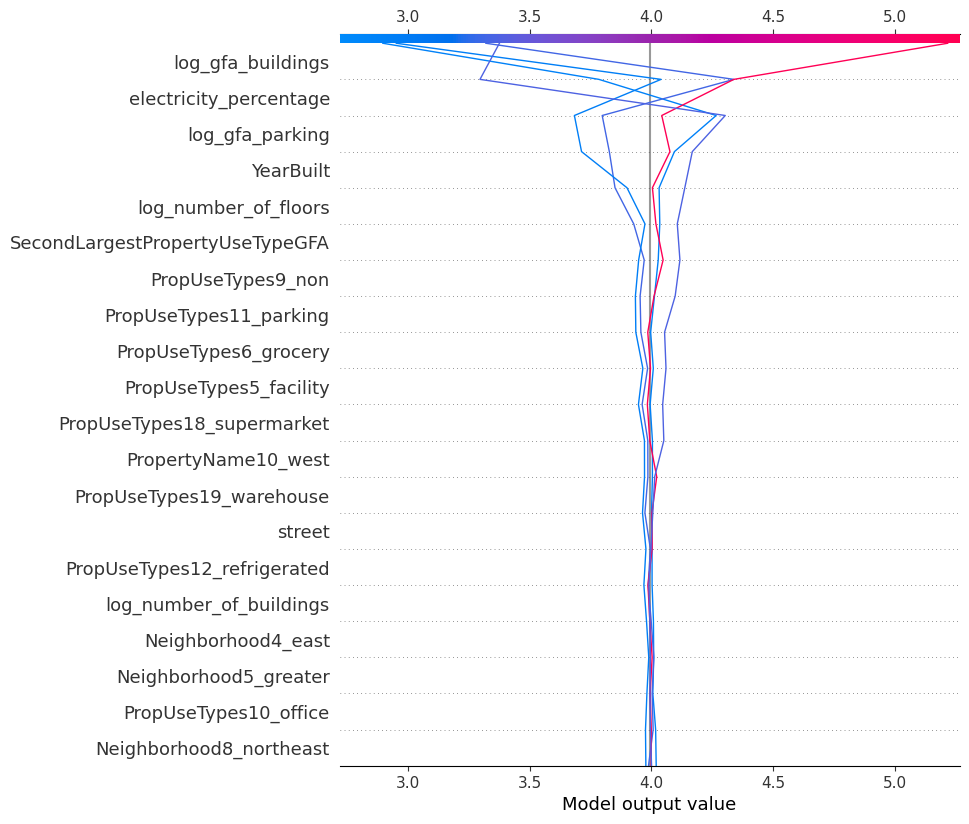

In [137]:
shap.decision_plot(
    expected_val,
    shap_vals.values[:5],
    feature_names=X_test.columns.tolist()
)

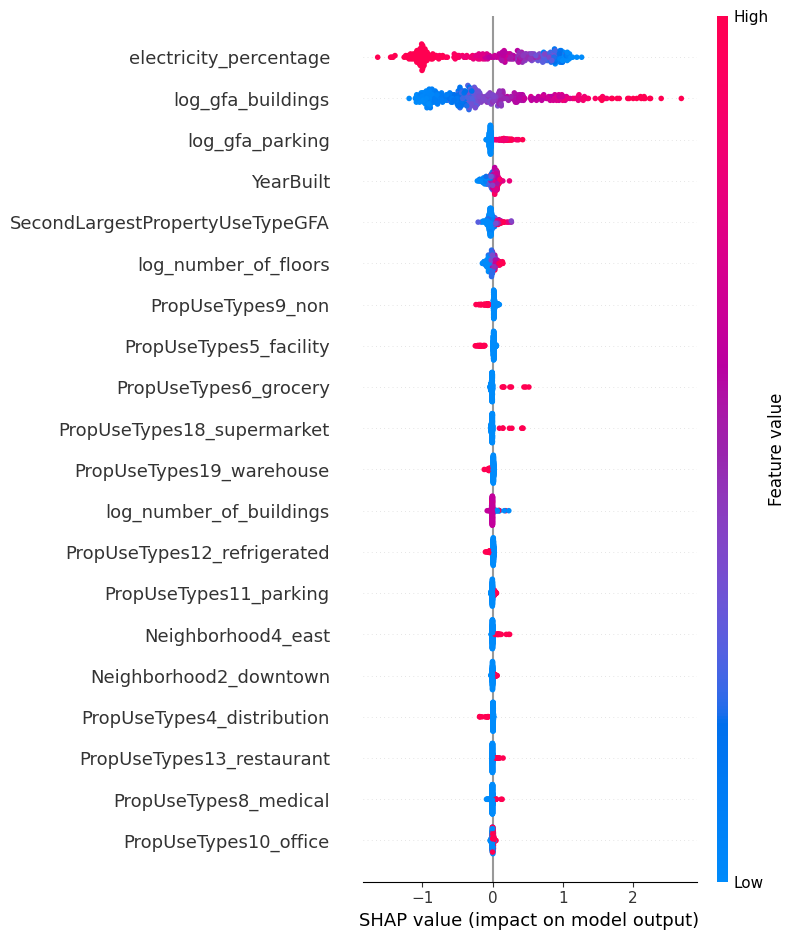

In [138]:
shap.summary_plot(
    shap_vals,
    features = X_test,
    feature_names=X_test.columns.tolist()
)

# With ENERGY STAR Score

## Train Test Split

In [139]:
X_ESS = data_with_energy_score.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis=1)
y_ESS = data_with_energy_score['TotalGHGEmissions']

X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(
    X_ESS, y_ESS, test_size=0.2, random_state=42
)

## Random Forest Regressor

In [140]:
rf_reg_ESS = RandomForestRegressor(random_state=42)

grid_search_rf_ESS = GridSearchCV(
    rf_reg_ESS,
    param_grid_rf,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1
)

In [141]:
grid_search_rf_ESS.fit(X_train_ESS, y_train_ESS)

GridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [None, 2, 5, 10],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}],
             return_train_score=True, scoring='r2')

### Results Cross Validation

In [142]:
# Get mean test scores from cross validation
rslt = grid_search_rf_ESS.cv_results_.get("mean_test_score")

# Sort the best estimators based on these mean scores
rank = 3
ranked_indices = np.argsort(rslt)[-rank:][::-1]

print(f"Top {rank} estimators:")

for i, (param, score) in enumerate(zip(
    np.array(grid_search_rf.cv_results_.get("params"))[ranked_indices],
    np.round(rslt[ranked_indices], 5)
)):
    print(f"Estimator {i + 1}  - ", *[f"{key}={val} " for key, val in param.items()], f"-->  r2={score:.5f}")

Top 3 estimators:
Estimator 1  -  max_depth=10  min_samples_split=2  n_estimators=200  -->  r2=0.55822
Estimator 2  -  max_depth=None  min_samples_split=5  n_estimators=200  -->  r2=0.55621
Estimator 3  -  max_depth=10  min_samples_split=5  n_estimators=200  -->  r2=0.55284


In [145]:
best_rf_model_ESS = grid_search_rf_ESS.best_estimator_
y_pred_rf_ESS = best_rf_model_ESS.predict(X_test_ESS)
r2_rf = r2_score(y_test_ESS, y_pred_rf_ESS)

print(f'Random Forest Regressor with ENERGY STAR Score - Best R^2 Score : {r2_rf:.5f}')

Random Forest Regressor with ENERGY STAR Score - Best R^2 Score : 0.61726
